In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# =================================================================================================================================

# DOMAIN
X_MIN = -10
X_MAX = 10

# INITIAL (+c)
IC_X = 0.0 # at this value
IC_VALUE = 0.0 # we expect this value

# BOUNDARY LOCATIONS
BC_LEFT_X = X_MIN
BC_RIGHT_X = X_MAX


# BOUNDARY CONDITIONS, determines the value at boundaries
BC_LEFT_VALUE = torch.sin(torch.tensor(X_MIN))
BC_RIGHT_VALUE = torch.sin(torch.tensor(X_MAX))

# PINN details
epochs=3000
N_collocation=100 # number of data points seen per epoch

width=32 #number of neurons per layer
depth=2 #number of layers

# DIFFERENTIAL EQUATION
# du/dx = RHS(x, u)
def true_solution(x):
    return torch.sin(x)          # <-- optional / removable

def true_derivative(x):
    return torch.cos(x)          # <-- optional / removable

# =================================================================================================================================

class PINN(nn.Module):
    def __init__(self, width=width, depth=depth):
        super().__init__()

        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers.append(nn.Linear(width, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def sample_x(N):
    x = torch.rand(N, 1) * (X_MAX - X_MIN) + X_MIN
    x.requires_grad_(True)
    return x

def du_dx(u, x):
    return torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

def physics_residual(model, x):
    u = model(x)
    u_x = du_dx(u, x)
    return u_x - RHS(x, u)

def initial_condition_loss(model):
    x0 = torch.tensor([[IC_X]], requires_grad=True)
    u0 = model(x0)
    return (u0 - IC_VALUE) ** 2

def boundary_loss(model):
    device = next(model.parameters()).device

    x_left = torch.tensor([[BC_LEFT_X]], dtype=torch.float32, device=device)
    x_right = torch.tensor([[BC_RIGHT_X]], dtype=torch.float32, device=device)

    u_left = model(x_left)
    u_right = model(x_right)

    loss_left = (u_left - BC_LEFT_VALUE)**2
    loss_right = (u_right - BC_RIGHT_VALUE)**2

    return loss_left + loss_right

def RHS(x, u):
    return torch.cos(x)

def loss_function(model, x_collocation):
    # PDE loss
    x_collocation.requires_grad_(True)
    u = model(x_collocation)

    du_dx = torch.autograd.grad(
        u, x_collocation,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    pde_loss = torch.mean((du_dx - RHS(x_collocation, u))**2)

    # IC loss
    x_ic = torch.tensor([[IC_X]])
    u_ic = model(x_ic)
    ic_loss = (u_ic - IC_VALUE)**2

    # BC loss
    bc_loss = boundary_loss(model)

    return pde_loss + ic_loss + bc_loss
def train_pinn(model, epochs=epochs, N_collocation=N_collocation, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    with tqdm(total=epochs, desc="Training PINN") as pbar:
        for epoch in range(epochs):
            optimizer.zero_grad()

            x = sample_x(N_collocation)
            loss = loss_function(model, x)

            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=f"{loss.item():.6e}")
            pbar.update(1)

def evaluate_pinn(model, N_eval=200):
    x_eval = torch.linspace(X_MIN, X_MAX, N_eval).view(-1, 1)
    x_eval.requires_grad_(True)

    u_pred = model(x_eval)
    u_x = du_dx(u_pred, x_eval)
    residual = u_x - RHS(x_eval, u_pred)

    print("u(IC):", model(torch.tensor([[IC_X]])).item())
    print("Mean residual:", torch.mean(torch.abs(residual)).item())
    print("Max residual:", torch.max(torch.abs(residual)).item())

    # Solution plot
    plt.figure()
    plt.plot(x_eval.detach(), u_pred.detach(), label="PINN")
    if true_solution is not None:
        plt.plot(x_eval.detach(), true_solution(x_eval.detach()), "--", label="True")
    plt.legend()
    plt.title("Solution")
    plt.show()

    # Derivative plot
    plt.figure()
    plt.plot(x_eval.detach(), u_x.detach(), label="PINN derivative")
    if true_derivative is not None:
        plt.plot(x_eval.detach(), true_derivative(x_eval.detach()), "--", label="True")
    plt.legend()
    plt.title("Derivative")
    plt.show()

    # Residual plot
    plt.figure()
    plt.plot(x_eval.detach(), residual.detach())
    plt.title("Physics Residual")
    plt.show()

    # Optional MSE
    if true_solution is not None:
        mse = torch.mean((u_pred - true_solution(x_eval))**2)
        print("MSE vs true:", mse.item())

Training PINN: 100%|████████████████████████████████████████████| 3000/3000 [00:30<00:00, 99.94it/s, loss=3.729006e-02]


u(IC): -0.006385117769241333
Mean residual: 0.11557670682668686
Max residual: 0.6348252296447754


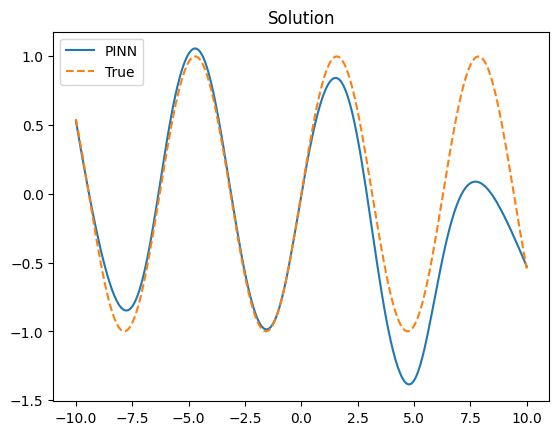

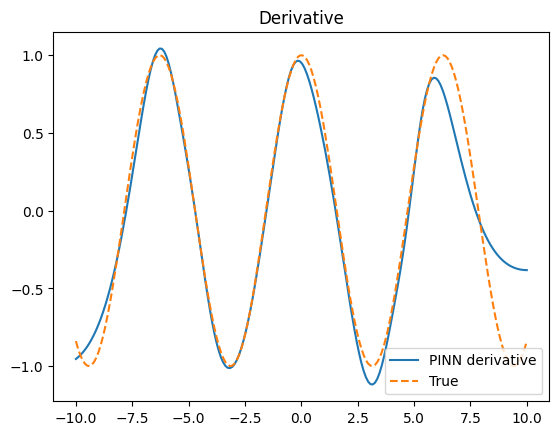

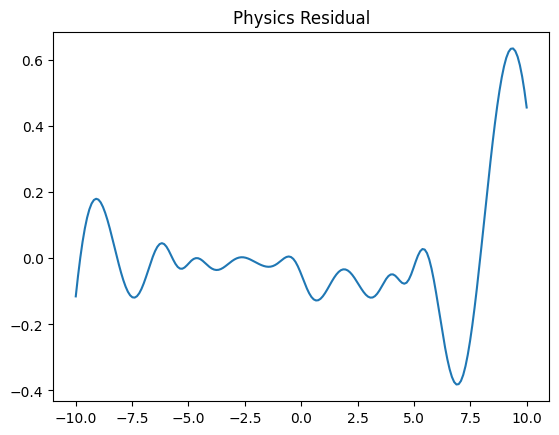

MSE vs true: 0.11142342537641525


In [2]:
model = PINN(width=width, depth=depth)
train_pinn(model)
evaluate_pinn(model)

In [3]:
for name, param in model.named_parameters():
    print(name)
    print(param.detach().cpu().numpy())
    print()


net.0.weight
[[-0.7910852 ]
 [ 0.5750684 ]
 [ 0.4769089 ]
 [ 0.8571325 ]
 [ 0.8338208 ]
 [ 0.64961326]
 [-0.55547374]
 [-0.63444203]
 [ 0.6641138 ]
 [ 0.40229082]
 [-0.7293939 ]
 [ 0.48055953]
 [-0.4878629 ]
 [ 0.49558982]
 [-0.5541536 ]
 [ 0.73285407]
 [-0.10323726]
 [-0.4976079 ]
 [-0.86976296]
 [-0.20414774]
 [ 0.54364085]
 [-0.5330021 ]
 [ 0.7978204 ]
 [-0.57086104]
 [ 0.7445679 ]
 [-0.7668897 ]
 [-0.54102856]
 [-0.81464833]
 [-0.6044059 ]
 [-0.6383957 ]
 [ 0.56654745]
 [-0.5697813 ]]

net.0.bias
[ 0.18965602 -1.8809038   1.9109898  -0.5283219   0.10752186 -0.66142356
 -0.24241191  2.3257213   1.4912019   0.24298611  0.9618213   2.7020657
 -2.0831442   1.7969127   0.48021752  0.35808992 -0.79372585  2.4938622
 -0.17896064  1.7534103  -1.6151055  -1.6726516  -0.6504339   0.7713644
  0.49647567 -0.81310546  0.7489783  -0.3478513  -1.303338    0.18277147
  0.718133    1.742553  ]

net.2.weight
[[-0.16610615 -0.655972   -0.0724987  ...  0.0910973   0.20742738
   0.62261647]
 [-0.146468

In [4]:
import numpy as np

deg = 4
x = np.linspace(X_MIN, X_MAX, 1000)
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    y = model(x_t).numpy().flatten()

coeffs = np.polyfit(x, y, deg=deg)
print(coeffs)

[ 9.15485463e-05  1.07148365e-03 -1.00362843e-02 -8.30300257e-02
 -1.73103332e-02]


In [5]:
from pysr import PySRRegressor

model_sr = PySRRegressor(
    niterations=500,
    unary_operators=[
        "sin",
        "cos",
        "tan",
    ],
    binary_operators=[
        "+",
        "-",
        "*",
        "/",
    ],
    maxsize=10,
)


model_sr.fit(x.reshape(-1,1), y)
print(model_sr)


C:\Users\JWHardy\anaconda3\myana\Lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


C:\Users\JWHardy\anaconda3\myana\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 9.660e+04
Progress: 615 / 15500 total iterations (3.968%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.337e-01  0.000e+00  y = -0.16863
2           1.119e-01  1.355e+00  y = sin(x₀)
3           1.043e-01  7.019e-02  y = sin(sin(x₀))
4           8.341e-02  2.233e-01  y = sin(x₀) + -0.1687
5           7.583e-02  9.531e-02  y = sin(sin(x₀)) + -0.16869
6           5.318e-02  3.548e-01  y = (x₀ * -0.041918) + sin(x₀)
7           5.295e-02  4.392e-03  y = sin(x₀ * -0.042964) + sin(x₀)
8           2.472e-02  7.615e-01  y = ((x₀ * -0.041919) + sin(x₀)) + -0.1687
9           2.421e-02  2.113e-02  y = sin(x₀) + tan((x₀ - -4.0617) * -0.039523)
10          2.405e-02  6.586e-03  y = tan(tan((x₀ * -0.036999) + -0.15237)) + sin(x₀)
─────────────────────────

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                        -0.16862535   
	1        1.355107                                            sin(x0)   
	2        0.070190                                       sin(sin(x0))   
	3        0.223344                              sin(x0) + -0.16869536   
	4        0.095309                         sin(sin(x0)) + -0.16868852   
	5        0.354781                        (x0 / -23.851978) + sin(x0)   
	6        0.004392                    sin(x0 * -0.04296413) + sin(x0)   
	7  >>>>  0.761522       (sin(x0) + -0.1686893) + (x0 * -0.041919485)   
	8        0.021134     sin(x0) + tan((x0 - -4.060752) * -0.039529283)   
	9        0.132394  (sin(x0 / 1.015152) + (x0 * -0.044866137)) + -...   
	
	       loss  complexity  
	0  0.433740           1  
	1  0.111870           2  
	2  0.104287           3  
	3  0.083413           4  
	4  0.075830           5  
	5  